# README

- Data: https://www.kaggle.com/competitions/titanic/data
- My original GitHub notebook with markdown notes: [fastai/course22/06-why-you-should-use-a-framework.ipynb](https://github.com/prasanth-ntu/fastai-course22/blob/master/06-why-you-should-use-a-framework.ipynb)


## Introduction and set up

In [2]:
from pathlib import Path
import os
import kaggle
import zipfile

In [8]:
from fastai.tabular.all import *

In [7]:
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    path = Path('../input/titanic')
else:
    competition_name = 'titanic'
    path = Path(f'../{competition_name}')
    if not path.exists():
        kaggle.api.competition_download_cli(competition=competition_name)
        zipfile.ZipFile(file=f'{path}.zip').extractall(path)
    else:
        print (f"path: '{path}' exists")
print (f"Files: {os.listdir(path)}")

path: '../titanic' exists
Files: ['test.csv', 'train.csv', 'gender_submission.csv', 'sub.csv']


In [23]:
print (f"Default | numpy > printoptions > linewidth: {np.get_printoptions()['linewidth']}")
print (f"Default | pandas > display.width: {pd.get_option('display.width')}")
print (f"Default | pytorch > printoptions > linewidth: {80}")

np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

pd.options.display.float_format = "{:.2f}".format

Default | numpy > printoptions > linewidth: 140
Default | pandas > display.width: 140
Default | pytorch > printoptions > linewidth: 80


In [24]:
set_seed(42) # For reproducibility

## Prep the data

In [79]:
df = pd.read_csv(f"{path}/train.csv")
print (df.shape)
df.head(1)

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [74]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [75]:
def add_features(df):
    '''Feature engineering (Creating new features)'''
    df['LogFare'] = np.log1p(df['Fare'])
    df['Deck'] = df['Cabin'].str[0].map({
        'A': 'ABC', 'B': 'ABC', 'C': 'ABC',
        'D': 'DE', 'E': 'DE',
        'F': 'FG', 'G': 'FG',
    })
    df['Family'] = df['Parch'] + df['SibSp']
    df['Alone'] = df['Family']==0
    df['TicketFreq'] = df.groupby(['Ticket'])['Ticket'].transform('count')
    df['Title'] = df['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    # df['Title'] = df['Title'].map(dict(Mr='Mr', Miss='Miss', Mrs='Mrs', Master='Master')).value_counts(dropna=False)
add_features(df)

In [76]:
print (df.shape)
df.head(1)

(891, 18)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare,Deck,Family,Alone,TicketFreq,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S,2.11,NaN,1,False,1,Mr


In [72]:
splits = RandomSplitter(seed=42)(df)

In [78]:
# Getting the data ready for training
dls = TabularPandas(
    df=df, splits=splits,
    # Turn strings into categories, fill missing values in numeric cols with median, normalize all numeric cols
    procs=[Categorify, FillMissing, Normalize], 
    cat_names=['Sex', 'Pclass', 'Embarked', 'Deck', 'Title'],
    cont_names = ['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family'],
    y_names='Survived',
    y_block=CategoryBlock(), # Tell fastai to do classification, not regression
).dataloaders(path='.')

## Train the model

In [82]:
learn = tabular_learner(dls=dls, metrics=accuracy, layers=[10,10])

SuggestedLRs(slide=0.12022644281387329, valley=0.009120108559727669)

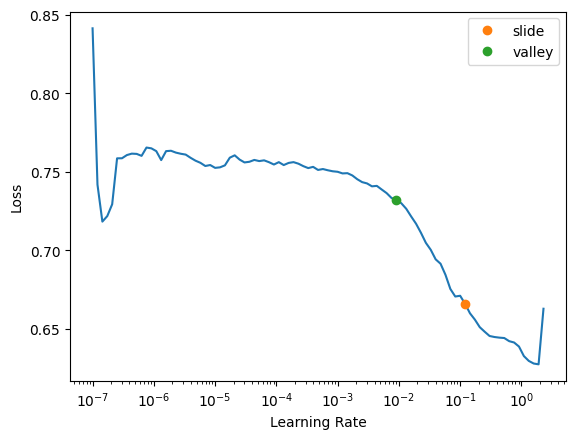

In [83]:
# Using fastai tools to find optimal learning rate
learn.lr_find(suggest_funcs=(slide, valley))

In [84]:
# Pick somewhere between slide and valley
learn.fit(n_epoch=16, lr=0.03)

epoch,train_loss,valid_loss,accuracy,time
0,0.572027,0.561040,0.595506,00:00
1,0.498225,0.480605,0.797753,00:00
2,0.462795,0.483255,0.820225,00:00
3,0.452451,0.483890,0.803371,00:00
4,0.449872,0.548933,0.825843,00:00
5,0.441701,0.491516,0.820225,00:00
6,0.432830,0.429545,0.820225,00:00
7,0.423594,0.426521,0.808989,00:00
8,0.417347,0.411991,0.820225,00:00
9,0.410619,0.441100,0.814607,00:00


In [ ]:
# The accuracy on validation set is closer to what we achieved in previous notebook 
# 05-linear-model-and-neural-net-from-scratch-clean.ipynb

## Submit to Kaggle

In [86]:
tst_df = pd.read_csv(f"{path}/test.csv")
print (tst_df.shape)
tst_df.head(2)

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.50,0,0,330911,7.83,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.00,1,0,363272,7.00,NaN,S


In [87]:
tst_df.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [92]:
tst_df['Fare'] = tst_df['Fare'].fillna(0)
add_features(tst_df)
print (tst_df.shape)
tst_df.head(2)

(418, 17)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare,Deck,Family,Alone,TicketFreq,Title
0,892,3,"Kelly, Mr. James",male,34.50,0,0,330911,7.83,NaN,Q,2.18,NaN,0,True,1,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.00,1,0,363272,7.00,NaN,S,2.08,NaN,1,False,1,Mrs


In [105]:
tst_dl = learn.dls.test_dl(tst_df)
tst_dl.xs.head(2)

,Sex,Pclass,Embarked,Deck,Title,Age_na,Age,SibSp,Parch,LogFare,Alone,TicketFreq,Family
0,2,3,2,0,12,1,0.40,-0.46,-0.46,-0.77,0.79,-0.58,-0.55
1,1,3,3,0,13,1,1.36,0.46,-0.46,-0.87,-1.26,-0.58,0.08


In [106]:
preds,_ = learn.get_preds(dl=tst_dl)
print (preds.shape)
preds[:5]

torch.Size([418, 2])


tensor([[0.8885, 0.1115],
        [0.5869, 0.4131],
        [0.9352, 0.0648],
        [0.9204, 0.0796],
        [0.2361, 0.7639]])

In [108]:
tst_df['Survived'] = (preds[:,1]>0.5).int()
sub_df = tst_df[['PassengerId', 'Survived']]
sub_df.to_csv('sub.csv', index=False)

In [109]:
!head '../sub.csv'

PassengerId,Survived
892,0
893,1
894,0
895,0
896,1
897,0
898,1
899,0
900,1


## Ensembling

In [129]:
def ensemble(dls, tst_dl):
    learn = tabular_learner(dls=dls, metrics=accuracy, layers=[10,10])
    with learn.no_bar(), learn.no_logging():
        learn.fit(n_epoch=16, lr=0.03)
    preds,_ = learn.get_preds(dl=tst_dl)
    return preds

In [132]:
# Create 5 separate models, each trained with different random coeffs during init, and average the results
learns = [ensemble(dls, tst_dl) for _ in range(5)]
print (len(learns))
print (learns[0].shape)

5
torch.Size([418, 2])


In [150]:
print (torch.stack(learns).shape)

torch.Size([5, 418, 2])


In [151]:
ens_preds = torch.stack(learns).mean(axis=0)
print (ens_preds.shape)

torch.Size([418, 2])


In [149]:
tst_df['Survived'] = (ens_preds[:,1]>0.5).int()
sub_df = tst_df[['PassengerId', 'Survived']]
sub_df.to_csv('sub.csv', index=False)

In [152]:
!head '../sub.csv'

PassengerId,Survived
892,0
893,1
894,0
895,0
896,1
897,0
898,1
899,0
900,1


## Final thoughts